## Обучить СНС с помощью Transfer Learning на датасете Food-101

Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

### Загрузка датасета Food-101

In [2]:
tfds.disable_progress_bar()
(train_ds, valid_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]', 'validation'],
)
labels = open('labels.txt', 'rb').read().decode(encoding='utf-8')

In [3]:
with open('labels.txt', 'r') as f:
    labels = [line.strip() for line in f]
num_classes = len(labels)

### Визуализация датасета Food-101

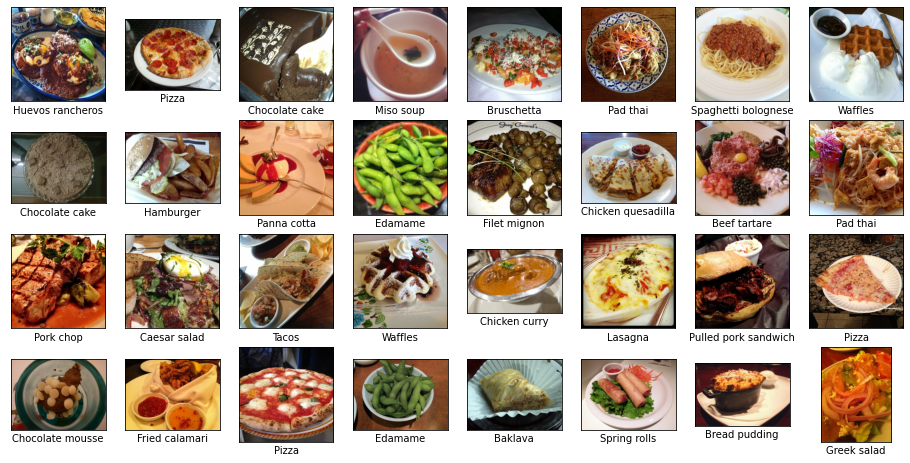

In [4]:
some_samples = [x for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j][0])
    plt.xticks([]), plt.yticks([])
    plt.xlabel(labels[some_samples[j][1]])
plt.show()

### Создание пайплайна данных

In [5]:
INP_SIZE = 224
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

valid_ds = valid_ds.shuffle(buffer_size=1000)
valid_ds = valid_ds.map(prepare)
valid_ds = valid_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

### Подготовка модели CNN с аугментацией

In [6]:
img_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.15),
    tf.keras.layers.experimental.preprocessing.RandomFlip(),
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
])



base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))

inputs = layers.Input(shape=(INP_SIZE, INP_SIZE, 3))
x = img_augmentation(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# fix train, not learning first layers
for layer in base_model.layers:
    layer.trainable = False



### Подготовка к обучению 


In [7]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_model = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    name='sparse_categorical_crossentropy'
)

model.compile(optimizer=optimizer,
              loss=loss_model,
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',
                                                    restore_best_weights=True)


### Model Summary

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_____________________________________________

### Обучение модели

In [9]:
%%time

history = model.fit(
    train_ds,
    epochs=150,
    validation_data=valid_ds,
    callbacks=[early_stopping])


Epoch 1/150
2130/2130 [==============================] - 91s 41ms/step - loss: 2.5258 - accuracy: 0.3932 - val_loss: 1.9128 - val_accuracy: 0.5123
Epoch 2/150
2130/2130 [==============================] - 87s 41ms/step - loss: 2.1431 - accuracy: 0.4760 - val_loss: 1.8092 - val_accuracy: 0.5446
Epoch 3/150
2130/2130 [==============================] - 91s 42ms/step - loss: 2.0862 - accuracy: 0.4859 - val_loss: 1.8087 - val_accuracy: 0.5456
Epoch 4/150
2130/2130 [==============================] - 89s 42ms/step - loss: 2.0534 - accuracy: 0.4960 - val_loss: 1.7698 - val_accuracy: 0.5527
Epoch 5/150
2130/2130 [==============================] - 89s 41ms/step - loss: 2.0291 - accuracy: 0.4994 - val_loss: 1.8197 - val_accuracy: 0.5438
Epoch 6/150
2130/2130 [==============================] - 90s 42ms/step - loss: 2.0240 - accuracy: 0.5030 - val_loss: 1.7729 - val_accuracy: 0.5531
Epoch 7/150
2130/2130 [==============================] - 89s 42ms/step - loss: 2.0255 - accuracy: 0.5020 - val_loss: 1

### Оценка качества модели

In [10]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 22s 99ms/step - loss: 1.5452 - accuracy: 0.5904
Wall time: 22.3 s


[1.5451570749282837, 0.5903791189193726]

### Подготовка модели CNN без аугментации

In [11]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)


model2 = tf.keras.Model(inputs=base_model.input, outputs=outputs)

# fix train, not learning first layers
for layer in base_model.layers:
    layer.trainable = False

### Подготовка к обучению 


In [12]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_model = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    name='sparse_categorical_crossentropy'
)

model2.compile(optimizer=optimizer,
              loss=loss_model,
              metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min',
                                                    restore_best_weights=True)


### Model Summary

In [13]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

block_9_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_9_depthwise[0][0]          
__________________________________________________________________________________________________
block_9_depthwise_relu (ReLU)   (None, 14, 14, 384)  0           block_9_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_9_project (Conv2D)        (None, 14, 14, 64)   24576       block_9_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_9_project_BN (BatchNormal (None, 14, 14, 64)   256         block_9_project[0][0]            
__________________________________________________________________________________________________
block_9_add (Add)               (None, 14, 14, 64)   0           block_8_add[0][0]                
                                                                 block_9_project_BN[0][0]         
__________

### Обучение модели

In [14]:
%%time

history2 = model2.fit(
    train_ds,
    epochs=150,
    validation_data=valid_ds,
    callbacks=[early_stopping])


Epoch 1/150
2130/2130 [==============================] - 82s 38ms/step - loss: 2.1942 - accuracy: 0.4613 - val_loss: 1.7615 - val_accuracy: 0.5532
Epoch 2/150
2130/2130 [==============================] - 82s 39ms/step - loss: 1.7188 - accuracy: 0.5604 - val_loss: 1.7256 - val_accuracy: 0.5655
Epoch 3/150
2130/2130 [==============================] - 82s 39ms/step - loss: 1.6034 - accuracy: 0.5863 - val_loss: 1.7135 - val_accuracy: 0.5683
Epoch 4/150
2130/2130 [==============================] - 81s 38ms/step - loss: 1.5371 - accuracy: 0.6004 - val_loss: 1.7427 - val_accuracy: 0.5726
Epoch 5/150
2130/2130 [==============================] - 82s 39ms/step - loss: 1.4976 - accuracy: 0.6081 - val_loss: 1.7244 - val_accuracy: 0.5731
Epoch 6/150
2130/2130 [==============================] - 82s 38ms/step - loss: 1.4709 - accuracy: 0.6152 - val_loss: 1.7542 - val_accuracy: 0.5691
Epoch 7/150
2130/2130 [==============================] - 83s 39ms/step - loss: 1.4459 - accuracy: 0.6197 - val_loss: 1

### Оценка качества модели

In [15]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 20s 101ms/step - loss: 1.5442 - accuracy: 0.5907
Wall time: 20.2 s


[1.5441696643829346, 0.5907360315322876]

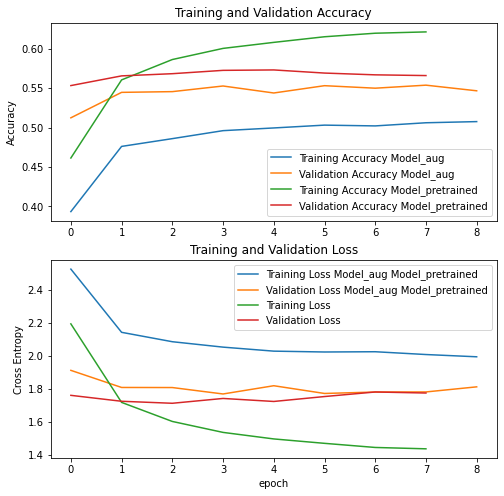

In [20]:
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc1, label='Training Accuracy Model_aug')
plt.plot(val_acc1, label='Validation Accuracy Model_aug')
plt.plot(acc2, label='Training Accuracy Model_pretrained')
plt.plot(val_acc2, label='Validation Accuracy Model_pretrained')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss1, label='Training Loss Model_aug Model_pretrained')
plt.plot(val_loss1, label='Validation Loss Model_aug Model_pretrained')
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Запуск предсказания на изображении

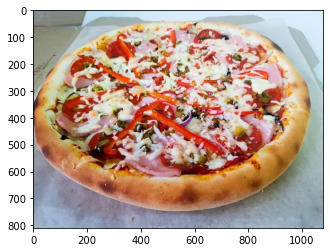

In [16]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

img = imageio.imread('pizza.jpg', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [17]:
pred = model2(img[None, ...], training=False)

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))

Prediction: apple_pie
